# Dirac-3 Quick Start

Entropy quantum computing (EQC) is a unique tool for optimization leveraging exotic effects in open quantum systems, including the quantum Zeno effect. Most quantum and quantum-inspired programming models, including quantum annealing models, are restricted to qubits. Dirac-3 hybrid quantum optimization machine, 3<sup>rd</sup> generation of EQC, allows the use of qudits, which are units of quantum information similar to qubits, but each taking more than two possible values. Be sure to read the [Qudit Basics](https://learn.quantumcomputinginc.com/learn/lessons/qudit-basics) to further understand the benefit of high dimensional encoding using qudits.

This tutorial serves as a quick starter guide, offering practical examples to help users learn the solver characteristics, submit problem, and interpret the results from Dirac-3 effectively.

## Device - Dirac-3

Dirac-3 solves quadratic Hamiltonians of up to 949 variables. It also solves highly complex problems with three and four-body interaction. For more details, see the [user guide](https://quantumcomputinginc.com/learn/dirac-3/dirac-3-users-guide). 

## Tutorial Structure

The goal of this tutorial is to explain how to work with Dirac-3. 

The first step is to turn an objective function into a Hamiltonian. It is important that the Hamiltonian is important in Hermitian form. That means the interaction matrices or tensors must be symmetric upon conjugation or transposition operations. 

For example, if the objective function is 

$$
E=x_1-x_2+x_1^2+bx_1x_2
$$

Then the Hamiltonian in the matrix form shall be (assuming $b$ is real)

$$
H=\begin{bmatrix} 1 & -1 \end{bmatrix}\begin{bmatrix}x_1\\ x_2\end{bmatrix}
 + \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix} 1 & b / 2 \\ b / 2 & 0 \end{bmatrix}
 \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} 
$$

for state vector $\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}$. Note that cross-term in the second part of the Hamiltonian is $b/2$. To code the Hamiltonian into Dirac-3, the linear and quadratic parts are defined separately as 

$$
C=\begin{bmatrix} 1 \\ -1\end{bmatrix}
$$

and 

$$
J=\begin{bmatrix} 1 & b/2 \\ b/2 & 0 \end{bmatrix}.
$$

These two matrices are input into the `sample_hamiltonian` method in the examples below.

In the following, we will use three different examples to illustrate how to prepare and submit problems.

1. The first is a simple example to help with understanding the use of the qudits.
2. The second example is a polynomial which will be used for demonstrating how different values of the summation constraint can be used to change the solution of the problem.
4. The third example is a simple problem which, like the first, is minimized by setting one value to the whole quantity of $R$. The difference is that there are three solutions at optimality. Repeated runs will reveal different solutions.

First, we'll get our Python environment set up. We need `numpy`, two methods to sample and evaluate quadratic Hamiltonians, respectively, and the connection to a device. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qci_client import QciClient
import os

url = "https://api.qci-prod.com"
q1 = QciClient(api_token=os.getenv("QCI_TOKEN"), url=url)

The `sample_hamiltonian` method takes six required arguments. `C` and `J` are the linear and quadratic terms of the polynomial. These matrices are dense and the method converts into a sparse format for the `process_job` call. The `sum_constraint` parameter is a value that indicates the total returned given solution vector must add up to. The `schedule` parameter takes four different values, 1, 2, 3 or 4.

1. This is the quickest execution. It has the lowest probability of obtaining high-quality solutions.
2. This execution takes more time, likely a few seconds, but has a higher probability of finding good solutions.
3. This option may take tens of seconds. The quality of these solutions is expected to be higher.
4. This is the longest-running relaxation option. It takes up to multiple minutes to run and has the highest probability of returning quality solutions.

The `solution_precision` parameter is a value that indicates how granular a solution should be. Use a value of 1 for integer solutions. Use decimals such as 0.1 or 0.05 for higher precision with the highest precision accepted being 0.00001. Specify a connected `EqcClient` in the `client` parameter. Suppress print statements in the call using a value of `True` for `suppress_output`.

In [2]:
def sample_hamiltonian(C : np.ndarray, J : np.ndarray, sum_constraint : float, schedule : int, solution_precision : float, client : QciClient):
    
    n = C.shape[0]
    H = np.hstack([C.reshape([n, 1]), J])
    ham_file = {"file_name": "qudit-tutorial-hame", "file_config": {"hamiltonian": {"data": H}}}
    file_id = client.upload_file(file=ham_file)["file_id"]
    job_tags = ["qudit-tutorial"]
    job_body = client.build_job_body(job_type="sample-hamiltonian", hamiltonian_file_id=file_id, 
                                     job_params={"device_type": "dirac-3", "num_samples": 1, "solution_precision": solution_precision,
                                                 "sum_constraint": sum_constraint, "relaxation_schedule": schedule}, job_tags=job_tags)
    response = client.process_job(job_body=job_body, wait=True)
    return response

def get_results(response):
    if "results" in response and response["results"] is not None:
        results = response["results"]
    else:
        if "job_info" in response and "job_result" in response["job_info"]:
            details = response["job_info"]["job_result"]
        else:
            details = None
        raise RuntimeError(f"Execution failed. See details: {details}")
    return results

## Qudit Domain
Dirac-3 uses qudits to solve discrete optimization problems.

The first example is a three-variable problem with uniform two-body interaction, whose solution corresponds to one variable taking on the total value of the summation constraint and the rest taking the value 0.

In the coding please note the `dtype` of `float32`. This is the digital precision for floating point numbers used in the gRPC protocol. A warning will be raised if higher precision decimal values are used.

In [3]:
h = np.array([
    [-1],
    [0],
    [0]
], dtype=np.float32
)
J= np.array([
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
], dtype=np.float32
)
h, J

(array([[-1.],
        [ 0.],
        [ 0.]], dtype=float32),
 array([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]], dtype=float32))

In [4]:
response = sample_hamiltonian(h, J, 400, 1, 0.1, qclient)
if "job_info" in response:
    print("Status:", response["job_info"]["job_status"])
    results = get_results(response)
    print("Energy:", results["energies"][0])
    print("Solution")
    print(results["solutions"][0])
    solution = np.array(results["solutions"][0])
    print("Solution Value (should match energy)", h.T@solution + solution.T@J@solution)
    x = np.array([400, 0, 0])
    print("Known ground state", h.T@x + x.T@J@x)
    print("With solution", x)
else:
    print(response)

2024-04-16 18:19:08 - Dirac allocation balance = 0 s (unmetered)
2024-04-16 18:19:08 - Job submitted: job_id='661ef95cbdefceebf853c237'
2024-04-16 18:19:08 - QUEUED
2024-04-16 18:19:53 - RUNNING
2024-04-16 18:20:06 - COMPLETED
2024-04-16 18:20:09 - Dirac allocation balance = 0 s (unmetered)
Status: {'submitted_at_rfc3339nano': '2024-04-16T22:19:08.696Z', 'queued_at_rfc3339nano': '2024-04-16T22:19:08.697Z', 'running_at_rfc3339nano': '2024-04-16T22:19:51.955Z', 'completed_at_rfc3339nano': '2024-04-16T22:20:05.232Z'}
Energy: -400
Solution
[400, 0, 0]
Solution Value (should match energy) [-400.]
Known ground state [-400.]
With solution [400   0   0]



## Dynamic Range

Solution precision is dictated by the machine sensitivity and precision, including those of the photon-counting modules and optoelectronic devices, and shot-noise limited quantum measurements. Dirac-3 has a dynamic range of at least 23 dB. This means that Hamiltonian coefficients having an absolute value smaller than ~1/200 of the peak coefficient value may not be recognized and will be effectively treated as 0 when encoding the Hamiltonian. In some cases, the dynamic range can reach as high as 40 dB. However, it is not guaranteed.

During computing cycles, each qudit takes discrete numbers of levels, which is at least 200, but can reach 10,000, as limited by the 23 dB or 40 dB dynamic range. At the output, however, the optimal solutions may consist of variables that have fractional components, as a result of normalization to the summation constraint. Thus when the number of levels is 200, each qudit value will be a multiple of R/200. 

Device sensitivity is not a controllable parameter and so the number of levels is not a part of problem formulation. More details on this are available in the Dirac-3 User Guide.


## Summation Constraint

The summation constraint is required to be some value between 1 and 10,000. This restriction is a property of Dirac-3.1 and not EQC in general. This constraint is helpful in some models and a formulation hurdle in others. In all formulations of TSP, for instance, the sum of a final solution is known beforehand. A Hamiltonian cycle (another one of those confusing terminologies that shows up when mathematicians and physicists work together) has exactly $n$ edges, where $n$ is the number of nodes in a graph. This means that solving a TSP with Dirac-3 requires setting the sum constraint equal to the number of nodes in the graph.

Other cases where the sparsity or sum of the solution is not known before solving can be solved with a couple of different approaches.

### Machine Slack Qudits
When formulating a model, it can be advantageous to add slack variables. To use this method when setting a summation constraint, formulate the Hamiltonian like normal, then determine a lower bound and an upper bound on the sum of the qudit values. Introduce an additional qudit into the formulated model which can sum to the upper bound minus the lower bound. This additional variable in the model will be ignored in the solution. See some of the more indepth examples, like Max Cut, to understand slack qudits in action. 



### Minimizing a simple polynomial

Let $H(x)=-5x_1x_3-4x_2^2-10x_1-10x_3$. This polynomial itself has no lower bound, but as we put a summation constraint, it does. If $\sum_i x_i = R$, then $H(s)$ has a minimum value that changes negatively with $R$ and changes the cardinality of $x$. Below are the results for different $R$ values.

In [5]:
h = np.array([[-10.],
              [  0.],
              [-10.]], dtype=np.float32)
J = np.array([[0.,    0.,   -2.5],
              [0.,   -4.,    0. ],
              [-2.5,   0.,    0. ]], dtype=np.float32)
for S in [2, 3, 4, 5, 6, 7]:
    print("**********************************")
    print(f"S={S}")
    response = sample_hamiltonian(h, J, S, 3, 0.1, qclient)
    results = get_results(response)
    print("Status:", response["job_info"]["job_status"])
    results = get_results(response)
    print("Energy:", results["energies"][0])
    print("Solution")
    print(results["solutions"][0])
    print()

**********************************
S=2
2024-04-16 18:20:28 - Dirac allocation balance = 0 s (unmetered)
2024-04-16 18:20:28 - Job submitted: job_id='661ef9acbdefceebf853c239'
2024-04-16 18:20:28 - QUEUED
2024-04-16 18:23:42 - RUNNING
2024-04-16 18:23:58 - COMPLETED
2024-04-16 18:24:00 - Dirac allocation balance = 0 s (unmetered)
Status: {'submitted_at_rfc3339nano': '2024-04-16T22:20:28.455Z', 'queued_at_rfc3339nano': '2024-04-16T22:20:28.455Z', 'running_at_rfc3339nano': '2024-04-16T22:23:40.526Z', 'completed_at_rfc3339nano': '2024-04-16T22:23:57.4Z'}
Energy: -24.9988518
Solution
[1.0151619, 0, 0.9848381]

**********************************
S=3
2024-04-16 18:24:08 - Dirac allocation balance = 0 s (unmetered)
2024-04-16 18:24:08 - Job submitted: job_id='661efa88bdefceebf853c23b'
2024-04-16 18:24:08 - QUEUED
2024-04-16 18:27:22 - RUNNING
2024-04-16 18:28:26 - COMPLETED
2024-04-16 18:28:28 - Dirac allocation balance = 0 s (unmetered)
Status: {'submitted_at_rfc3339nano': '2024-04-16T22:24:0

For reference, here is a job response that is returned in JSON from the REST API

In [6]:
response

{'job_info': {'job_id': '661efe5bbdefceebf853c243',
  'job_submission': {'job_tags': ['qudit-tutorial'],
   'problem_config': {'normalized_qudit_hamiltonian_optimization': {'hamiltonian_file_id': '661efe5b98263204a364e424'}},
   'device_config': {'dirac-3': {'num_samples': 1,
     'relaxation_schedule': 3,
     'solution_precision': 0.1,
     'sum_constraint': 7}}},
  'job_status': {'submitted_at_rfc3339nano': '2024-04-16T22:40:27.508Z',
   'queued_at_rfc3339nano': '2024-04-16T22:40:27.509Z',
   'running_at_rfc3339nano': '2024-04-16T22:43:37.648Z',
   'completed_at_rfc3339nano': '2024-04-16T22:43:54.313Z'},
  'job_result': {'file_id': '661eff2a98263204a364e428', 'device_usage_s': 2}},
 'status': 'COMPLETED',
 'results': {'counts': [1],
  'energies': [-131.2414703],
  'solutions': [[3.4593952, 1.03e-05, 3.5405946]],
  'distilled_energies': [-131.25],
  'distilled_solutions': [[3.5, 0, 3.5]]}}

## Degeneracy Demonstration

Dirac-3 will return various solutions to a problem with multiple solutions near the optimal value. 

Let's see what happens with a clearly degenerate problem. Take the first example modified to give the same weight to all the linear terms. Each solution: `[S, 0, 0]`, `[0, S, 0]` and `[0, 0, S]` give the same value for the Hamiltonian.

In [16]:
h = np.array([[-1],
              [-1],
              [-1]], dtype=np.float32)
J = np.array([[0, 1, 1],
              [1, 0, 1],
              [1, 1, 0]], dtype=np.float32)


2024-04-18 10:28:22 - Dirac allocation balance = 0 s (unmetered)
2024-04-18 10:28:23 - Job submitted: job_id='66212e07bdefceebf853c3a9'
2024-04-18 10:28:23 - QUEUED
2024-04-18 10:28:25 - RUNNING
2024-04-18 10:28:36 - COMPLETED
2024-04-18 10:28:38 - Dirac allocation balance = 0 s (unmetered)
2024-04-18 10:28:46 - Dirac allocation balance = 0 s (unmetered)
2024-04-18 10:28:46 - Job submitted: job_id='66212e1ebdefceebf853c3aa'
2024-04-18 10:28:46 - QUEUED
2024-04-18 10:28:49 - RUNNING
2024-04-18 10:29:02 - COMPLETED
2024-04-18 10:29:04 - Dirac allocation balance = 0 s (unmetered)
2024-04-18 10:29:12 - Dirac allocation balance = 0 s (unmetered)
2024-04-18 10:29:12 - Job submitted: job_id='66212e38bdefceebf853c3ab'
2024-04-18 10:29:12 - QUEUED
2024-04-18 10:29:15 - RUNNING
2024-04-18 10:29:28 - COMPLETED
2024-04-18 10:29:30 - Dirac allocation balance = 0 s (unmetered)
2024-04-18 10:29:38 - Dirac allocation balance = 0 s (unmetered)
2024-04-18 10:29:38 - Job submitted: job_id='66212e52bdefce

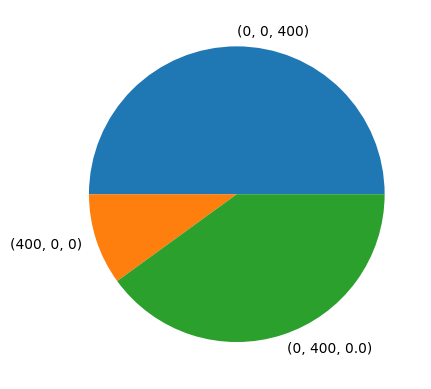

In [29]:
super_test = {}
energies_list = []
for i in range(10):
    response = sample_hamiltonian(h, J, 400, 2, 0.1, qclient)
    results = get_results(response)
    energies_list.append(results["energies"][0])
    solution = [round(v, 1) for v in results["solutions"][0]]
    solution = tuple(solution)
    if solution in super_test:
        super_test[solution] += 1
    else:
        super_test[solution] = 1
print("Solution           | Frequency")
for solution in super_test:
    print(solution, "  ", "*"*super_test[solution])
labels = list(super_test.keys())
sizes = [super_test[key] for key in labels]
fig, ax = plt.subplots()
patches, labels = ax.pie(sizes, labels=labels)